### Tune a CFD algorithm for the DG535 pulses acquired on Nov. 18, 2020 with the WDC v1 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
import matplotlib.colors as mplcolors
from matplotlib import pyplot as plt
from scipy.interpolate import UnivariateSpline

from common import *

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

clock_freq = 245.76  # MHz
template_splines = np.load('dg535_wdcv1_splines_11_18_2020.npy', allow_pickle=True)

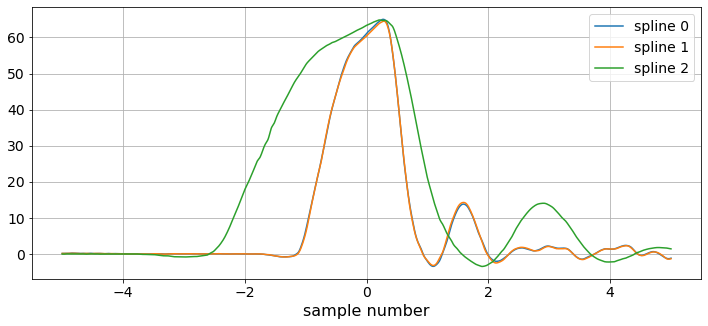

In [3]:
fig, ax = plt.subplots(figsize=(12, 5))
xs = np.linspace(-5, 5, 1000)
for i, s in enumerate(template_splines):
    ax.plot(xs, s(xs), label=f'spline {i}')
ax.legend()
ax.set_xlabel('sample number')
ax.grid()

Text(0.5, 0, 'sample number')

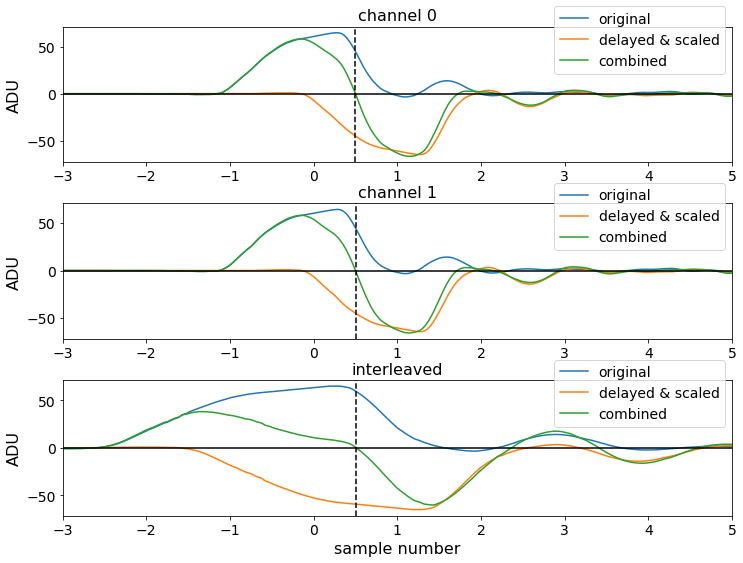

In [37]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 9))
plt.subplots_adjust(hspace=0.3)
for i, (templ, ax) in enumerate(zip(template_splines, axes.flat)):
    make_cfd_plot(1, 1, templ, ax)
    ax.set_title(f'channel {i}')
    ax.set_xlabel('')
ax.set_title('interleaved')
ax.set_xlabel('sample number')

In [5]:
def make_time_error_plot(delay, scale, templ, prefix, ax):
    shifts = np.linspace(0, 1, 1000)
    
    true_times = []
    reco_times = []
    peak_samples = []
    
    for shift in shifts:
        times = np.arange(40) - 20
        pulse = templ(times - shift)
        try:
            scaled_delayed, mixed, zero_crossing = cfd(
                pulse, delay, scale)
        except ValueError:
            # probably a failure to find a crossing close enough to the peak
            continue
        
        true_times.append(shift)
        reco_times.append(zero_crossing)
        peak_samples.append(np.argmax(pulse))
        
    true_times = np.array(true_times)
    reco_times = np.array(reco_times)
    
    ax.plot(true_times - true_times[0], reco_times - reco_times[0])
    
    ax.set_xlabel('true time')
    ax.set_ylabel('reco time')
    
    ax.set_title(f'{prefix}, Delay: {delay:.0f}, Scale: {scale:.0f}')
    
    return true_times, reco_times, peak_samples

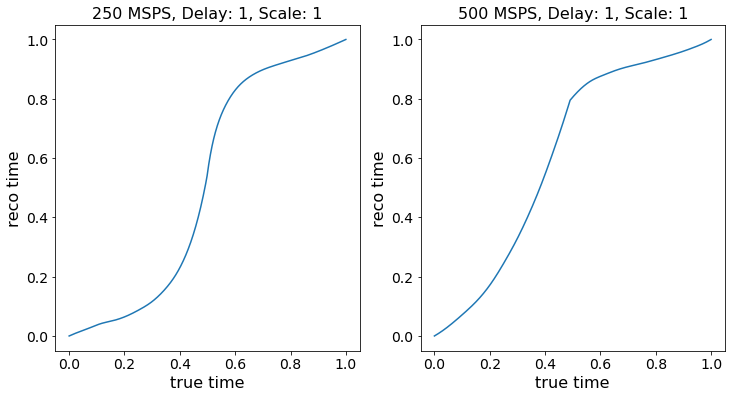

In [6]:
delay, scale = 1, 1
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axiter = axes.flat
_ = make_time_error_plot(delay, scale, template_splines[0], prefix='250 MSPS', ax=next(axiter))
_ = make_time_error_plot(delay, scale, template_splines[2], prefix='500 MSPS', ax=next(axiter))

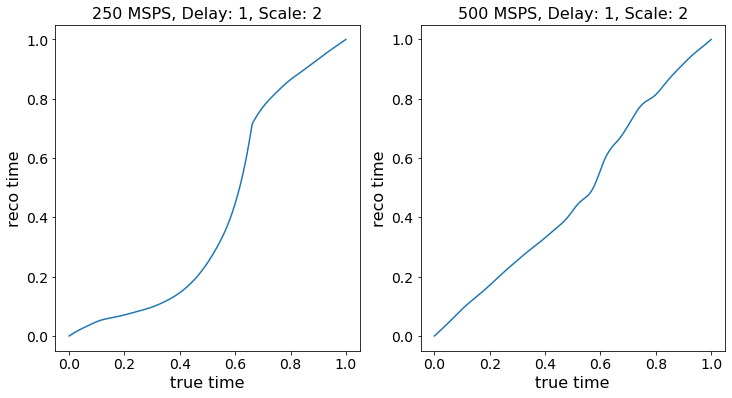

In [7]:
delay, scale = 1, 2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axiter = axes.flat
_ = make_time_error_plot(delay, scale, template_splines[0], prefix='250 MSPS', ax=next(axiter))
_ = make_time_error_plot(delay, scale, template_splines[2], prefix='500 MSPS', ax=next(axiter))

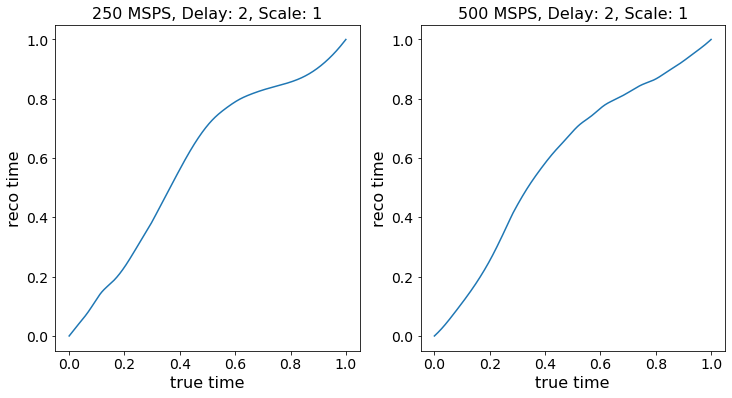

In [8]:
delay, scale = 2, 1
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axiter = axes.flat
_ = make_time_error_plot(delay, scale, template_splines[0], prefix='250 MSPS', ax=next(axiter))
_ = make_time_error_plot(delay, scale, template_splines[2], prefix='500 MSPS', ax=next(axiter))

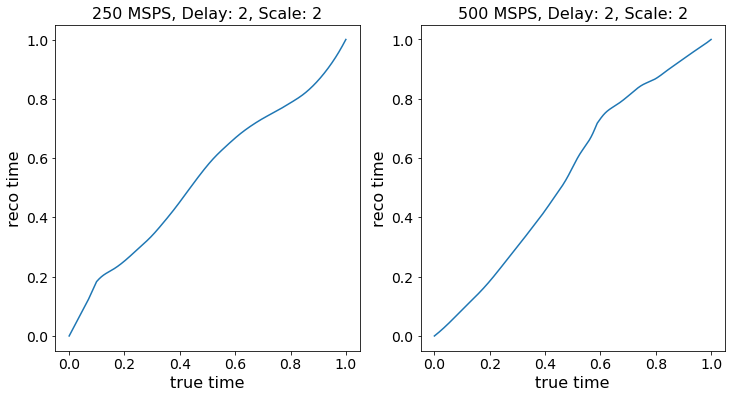

In [9]:
delay, scale = 2, 2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axiter = axes.flat
_ = make_time_error_plot(delay, scale, template_splines[0], prefix='250 MSPS', ax=next(axiter))
_ = make_time_error_plot(delay, scale, template_splines[2], prefix='500 MSPS', ax=next(axiter))

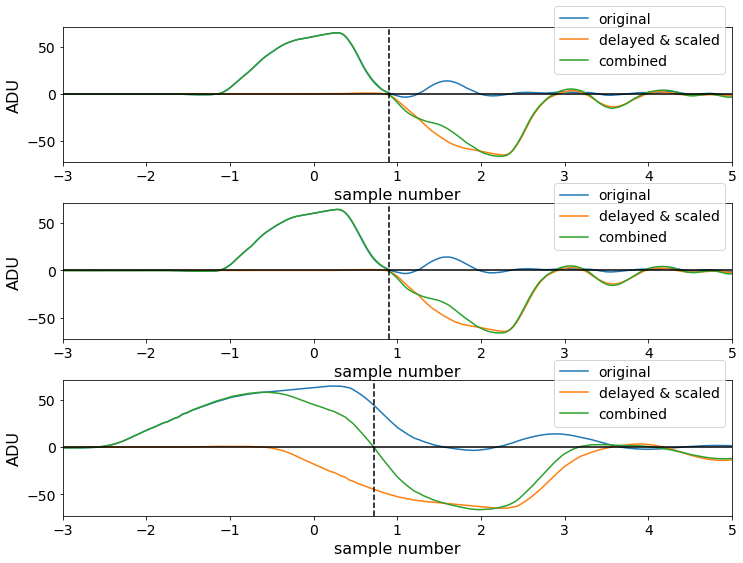

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 9))
plt.subplots_adjust(hspace=0.3)
for templ, ax in zip(template_splines, axes.flat):
    make_cfd_plot(2, 1, templ, ax)

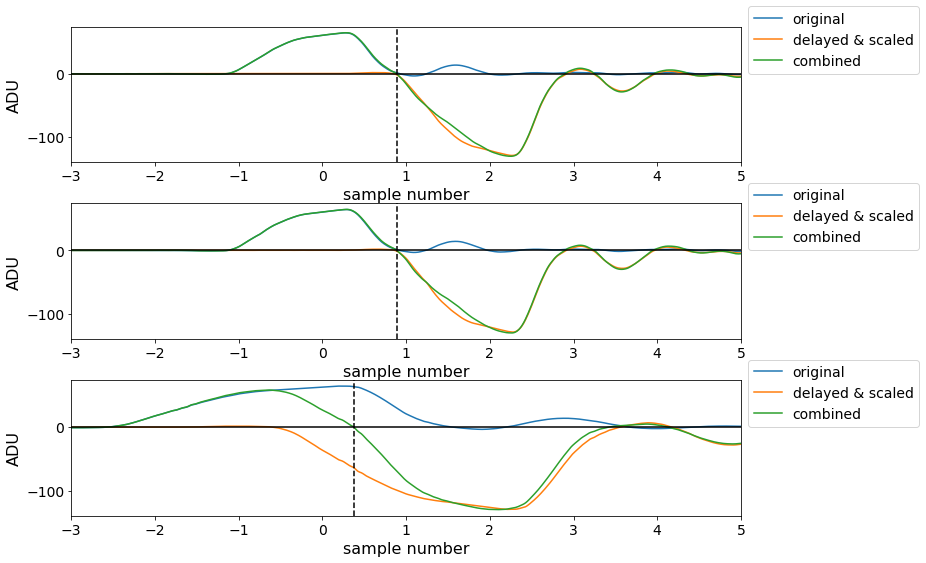

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 9))
plt.subplots_adjust(hspace=0.3)
for templ, ax in zip(template_splines, axes.flat):
    make_cfd_plot(2, 2, templ, ax)

### Try 1, 1 for 250 and 2, 1 for 500

In [12]:
def derive_phase_corrections(templ, prefix, delay, scale):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
    plt.subplots_adjust(wspace=0.3)
    
    axiter = axes.flat
    true, reco, peak_samples = make_time_error_plot(delay, scale, templ, prefix=prefix, ax=next(axiter))
    offset = reco[0]
    phase_zero = reco[0] - math.floor(reco[0])
    cfd_cor_spline = UnivariateSpline(reco - offset, true, s=0)

    ax = next(axiter)
    xs = np.linspace(0, 1, 1000)
    ax.plot(xs, cfd_cor_spline(xs))
    ax.set_title('correction')
    ax.set_xlabel('reco phase')
    ax.set_ylabel('true phase')
    
    ax = next(axiter)
    cor_phases = apply_phase_correction(np.array(reco), cfd_cor_spline, phase_zero)
    ax.plot(cor_phases - cor_phases[0], true)
    ax.set_xlabel('corrected reco phase')
    ax.set_ylabel('true phase')
    
    next(axiter).axis('off')

    return cfd_cor_spline, phase_zero

In [13]:
params_250 = (1, 1)
# params_250 = (2, 1)
# params_500 = (2, 2)
# params_500 = (1, 1)
params_500 = (2, 1)

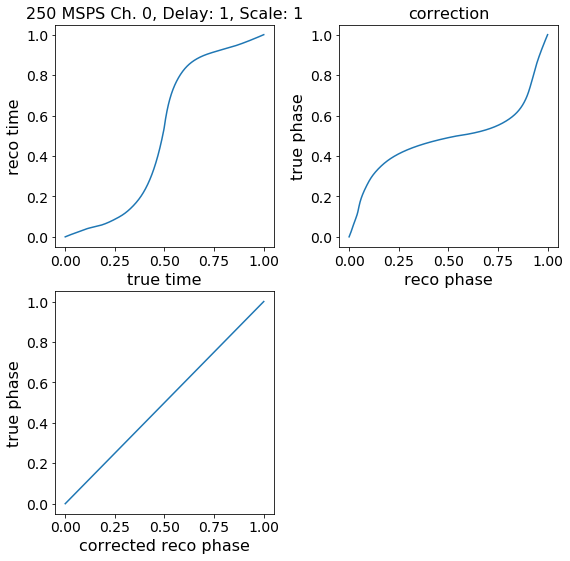

In [14]:
cor_250_0, zero_250_0 = derive_phase_corrections(template_splines[0], '250 MSPS Ch. 0', *params_250)

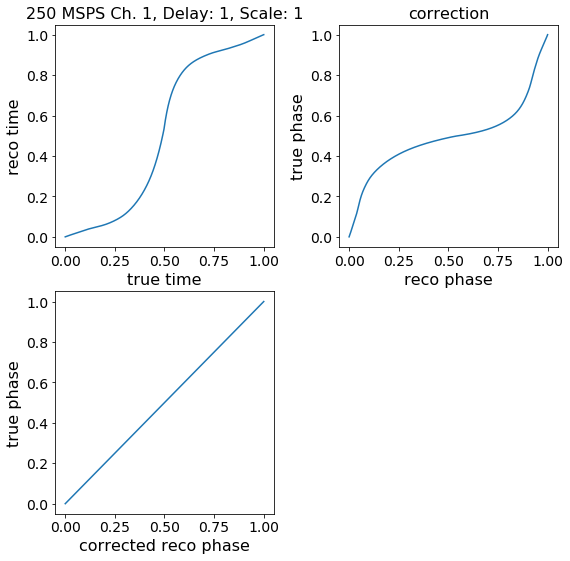

In [15]:
cor_250_1, zero_250_1 = derive_phase_corrections(template_splines[1], '250 MSPS Ch. 1', *params_250)

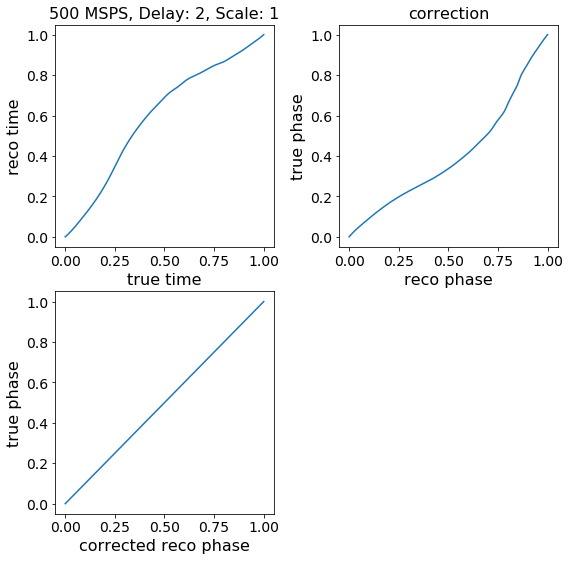

In [16]:
cor_500, zero_500 = derive_phase_corrections(template_splines[2], '500 MSPS', *params_500)

In [17]:
def cfd_time_reco(wfm, cor_spline, cor_zero, delay=1, scale=1):
    _,  _, raw_t = cfd(wfm, delay, scale)
    return apply_phase_correction(raw_t, cor_spline, cor_zero)

### Test and compare to template fit

In [18]:
single_pulse_data = load_data('template_pulses_11_18_2020-18_28_56.npz')

In [19]:
cfd_cors = ((cor_250_0, zero_250_0), (cor_250_1, zero_250_1), (cor_500, zero_500))
cfd_params = (params_250, params_250, params_500)

In [20]:
def plot_fit_and_cfd(wfm_ind, chan, suffix):
    fig, ax = plt.subplots(figsize=(9, 3))
    if chan != 2:
        wfm = single_pulse_data[wfm_ind][chan]
    else:
        wfm = build_combined_wfm(single_pulse_data[wfm_ind])
    
    templ = template_splines[chan]
    
    fit_res = template_fit(wfm, templ)
    plot_template_fit(wfm, templ, fit_res, color=colors[chan], ax=ax, legend=False)
    
    cfd_time = cfd_time_reco(wfm['samples'], *cfd_cors[chan], *cfd_params[chan])
    
    if chan == 2:
        cfd_time /= 2
    
    ax.axvline(cfd_time, color='black', linestyle='--', label='cfd time')
    
    chan_name = f'channel {chan}' if chan != 2 else 'interleaved'
    ax.set_title(f'{chan_name}, {suffix}')
    ax.legend()

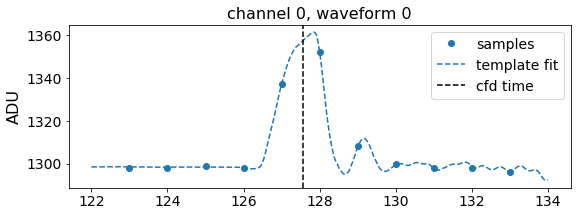

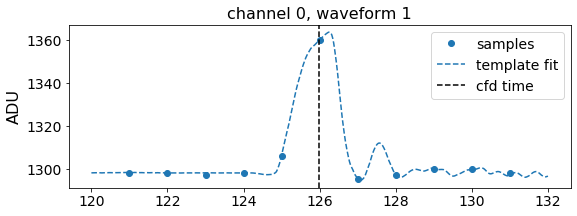

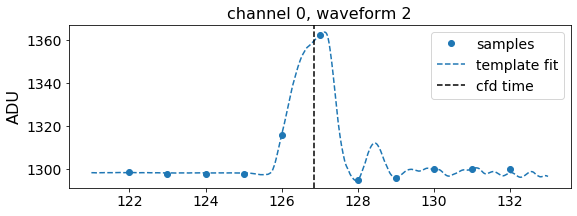

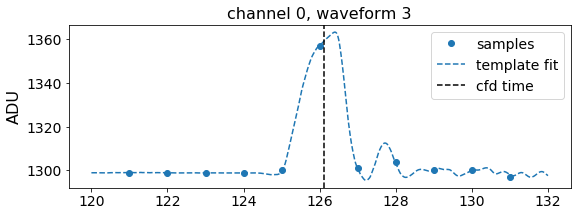

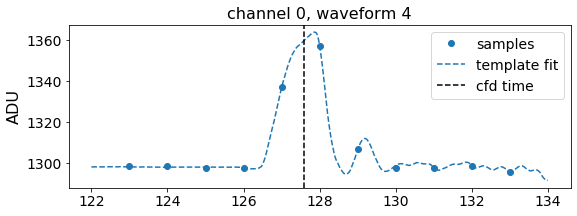

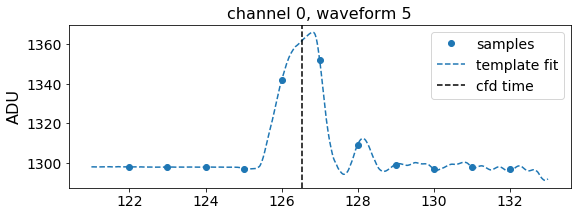

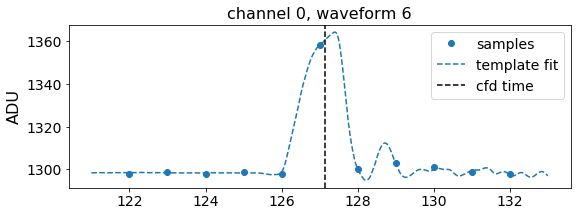

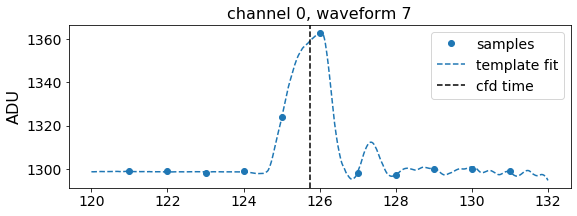

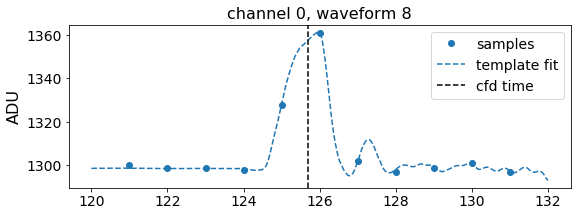

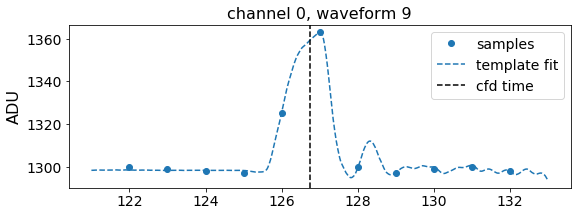

In [21]:
for i in range(10):
    plot_fit_and_cfd(i, 0, f'waveform {i}')

In [22]:
wfm = build_combined_wfm(single_pulse_data[0])

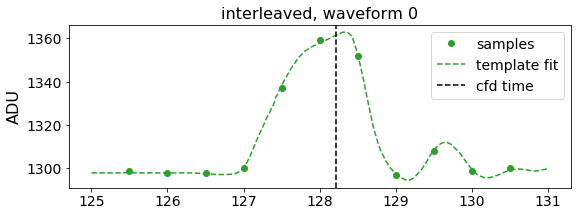

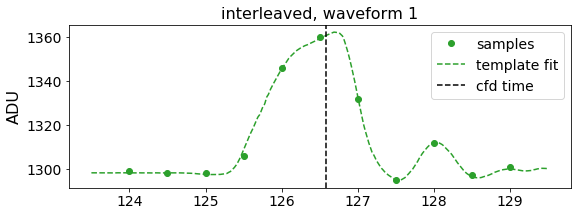

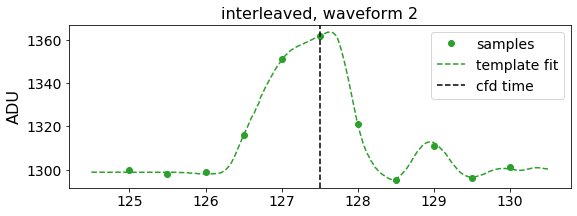

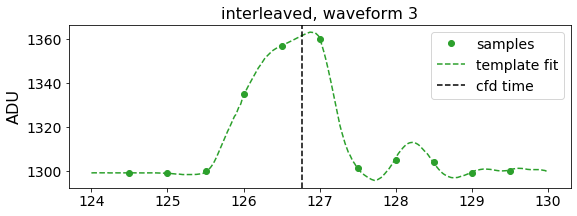

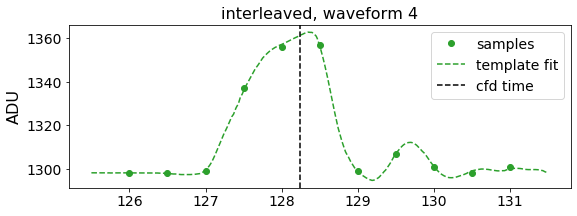

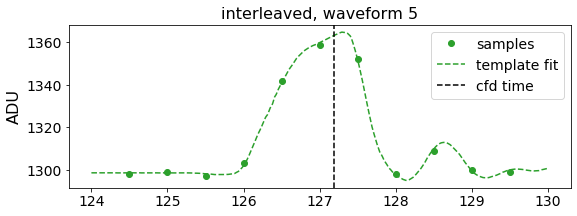

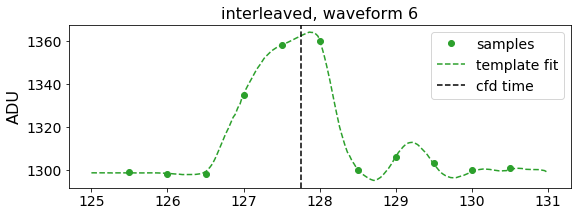

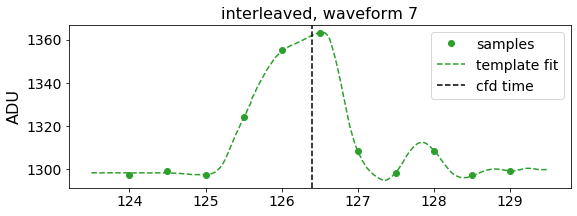

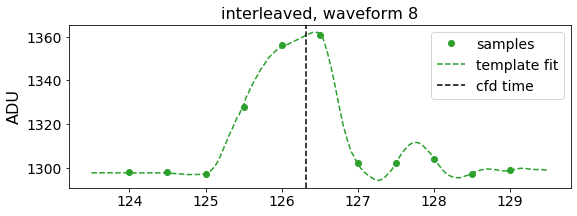

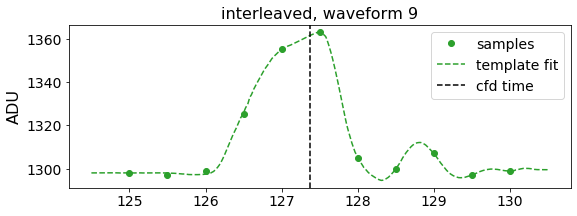

In [23]:
for i in range(10):
    plot_fit_and_cfd(i, 2, f'waveform {i}')

### for all channel 0 waveforms, get a template fit time and a CFD time with and without phase corrections

In [24]:
def reco_event(event):
    combined_wfm = build_combined_wfm(event)
    
    event_res = []
        
    for wfm, templ, cfd_par, cfd_cor in zip(list(event) + [combined_wfm], template_splines, 
                                                (cfd_params), cfd_cors):
        tf_res = template_fit(wfm, templ)
        cfd_time = cfd(wfm['samples'], *cfd_par)[-1]
        cor_cfd_time = apply_phase_correction(cfd_time, *cfd_cor)
        
        event_res.append((tf_res, cfd_time, cor_cfd_time))
        
    return event_res

In [25]:
%%time
reco_res = [reco_event(ev) for ev in single_pulse_data]

CPU times: user 42.5 s, sys: 109 ms, total: 42.6 s
Wall time: 42.7 s


In [26]:
def fit_cfd_diff_plot(chan, ax):
    cfd_diffs = np.array([res[chan][1] - res[chan][0][0][0][1] for res in reco_res])
    cor_diffs = np.array([res[chan][2] - res[chan][0][0][0][1] for res in reco_res])

    # shift mean of diffs to 0
    cfd_diffs -= np.mean(cfd_diffs)
    cor_diffs -= np.mean(cor_diffs)

    bins = np.linspace(-1, 1, 300)

    sample_freq = clock_freq if chan != 2 else 2 * clock_freq
    cfd_diff_hist, _ = np.histogram(cfd_diffs / sample_freq * 1000, bins)
    cor_diff_hist, _ = np.histogram(cor_diffs / sample_freq * 1000, bins)

    ax.step(bins[:-1], cfd_diff_hist, where='post', label='uncorrected')
    ax.step(bins[:-1], cor_diff_hist, where='post', label='with phase correction')

    ax.set_xlabel('cfd time $-$ template fit time (ns)')
    ax.set_ylabel('n waveforms')
    ax.legend()
    ax.grid()
    if chan == 0:
        ax.set_title('250 MSPS Ch. 0')
    elif chan == 1:
        ax.set_title('250 MSPS Ch. 1')
    elif chan == 2:
        ax.set_title('500 MSPS (interleaved)')

#     ax.set_yscale('log')

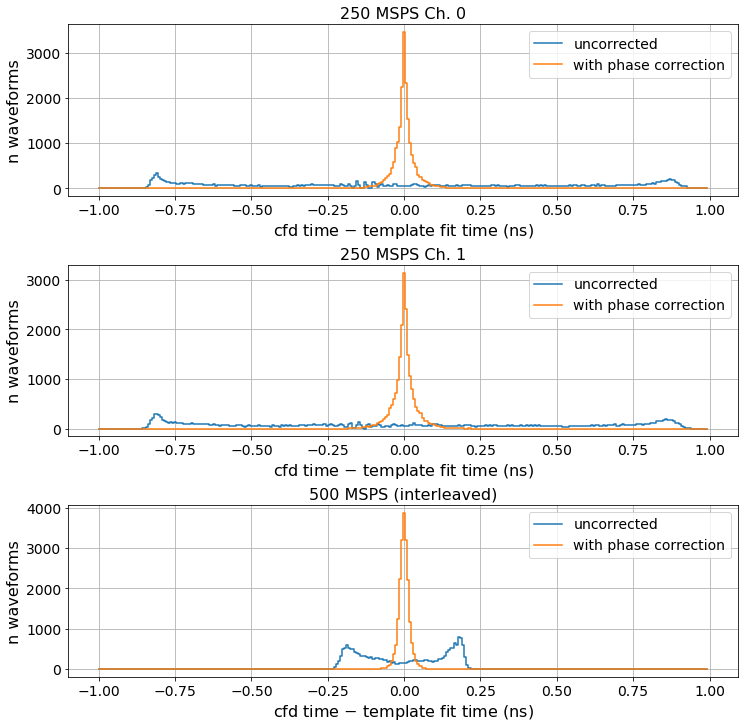

In [27]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))
plt.subplots_adjust(hspace=0.4)
for i, ax in enumerate(axes.flat):
    fit_cfd_diff_plot(i, ax)

In [28]:
0.25*clock_freq/1000

0.061439999999999995

In [29]:
def tf_vs_cfd_plot(chan, axes):    
    tf_t = np.array([res[chan][0][0][0][1] for res in reco_res])
    cfd_t = np.array([res[chan][1] for res in reco_res])
    cor_t = np.array([res[chan][2] for res in reco_res])
    
    if chan == 2:
        for t in tf_t, cfd_t, cor_t:
            t[:] = t / 2
    
    # cut out the handful of outliers, which are likely from triggering on the second pulse     
    diffs = cor_t - tf_t
    good_inds = (diffs - diffs.mean()) < 0.06
    
    for y, y_label, ax in zip([cfd_t, cor_t], ['raw CFD', 'corrected CFD'], axes):
        ax.plot(tf_t[good_inds], y[good_inds], 'o', markersize=0.5, alpha=0.3)
        
        line_int = (y[good_inds] - tf_t[good_inds]).mean()
        
        xs = np.array([tf_t.min(), tf_t.max()])
        
        ax.plot(xs, xs + line_int, 'k--', linewidth=2, label='ideal')
        
        ax.set_xlabel('template fit time (samples)')
        ax.set_ylabel(f'{y_label} (samples)')
    
        ax.grid()
        
        ax.legend()

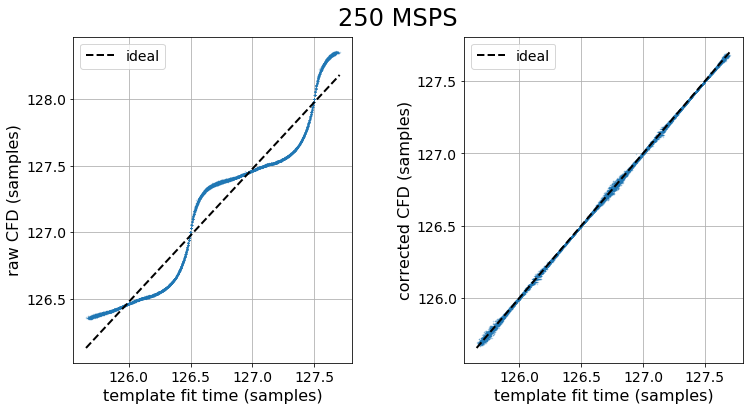

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('250 MSPS', fontsize=24, y=0.95)
plt.subplots_adjust(wspace=0.4)
tf_vs_cfd_plot(0, axes)

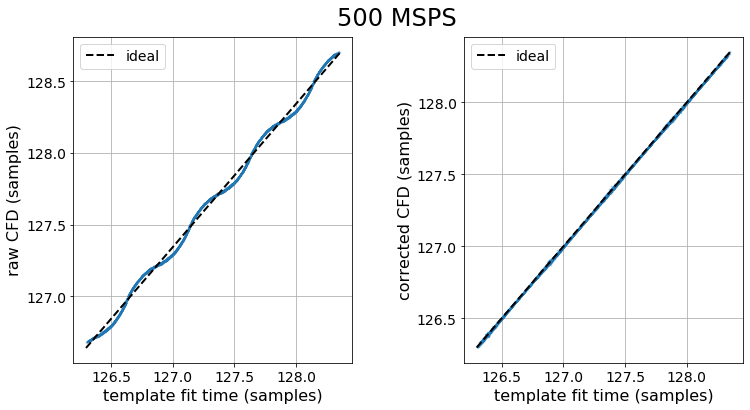

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('500 MSPS', fontsize=24, y=0.95)
plt.subplots_adjust(wspace=0.4)
tf_vs_cfd_plot(2, axes)

### Plot channel-channel timing diff with CFD, corrected CFD, template fit

In [32]:
def inter_chan_diff_plot(reco_res, bin_range, ax, skip_noncor=False):
    tf_diff = []
    cfd_diff = []
    cor_cfd_diff = []
    for ev in reco_res:
        tf_diff.append(ev[1][0][0][0][1] - ev[0][0][0][0][1])
        cfd_diff.append(ev[1][1] - ev[0][1])
        cor_cfd_diff.append(ev[1][2] - ev[0][2])
    tf_diff = np.array(tf_diff)
    cfd_diff = np.array(cfd_diff)
    cor_cfd_diff = np.array(cor_cfd_diff)
    
    bins = np.linspace(*bin_range, 250)
    for label, diff in zip(['template fit', 'corrected cfd', 'cfd'],
                           [tf_diff, cor_cfd_diff, cfd_diff]):
        if label == 'cfd' and skip_noncor:
            continue
        diff = diff * 1e3 / clock_freq
        std = diff.std()
        label += f', $\sigma$: {std*1000:.0f} ps'
        hist, _ = np.histogram((diff - diff.mean()), bins)
        ax.step(bins[:-1], hist, where='post', label=label)
        
    ax.set_xlabel('$t_{1} - t_{0}$ (ns)')
    ax.set_ylabel('n waveforms')
    ax.legend()

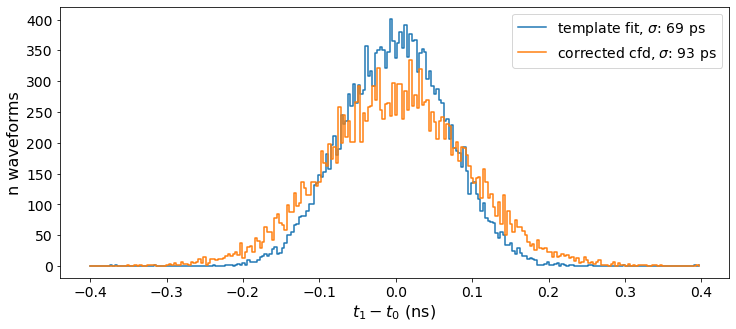

In [33]:
fig, ax = plt.subplots(figsize=(12, 5))
inter_chan_diff_plot(reco_res, (-0.400, 0.400), ax, True)

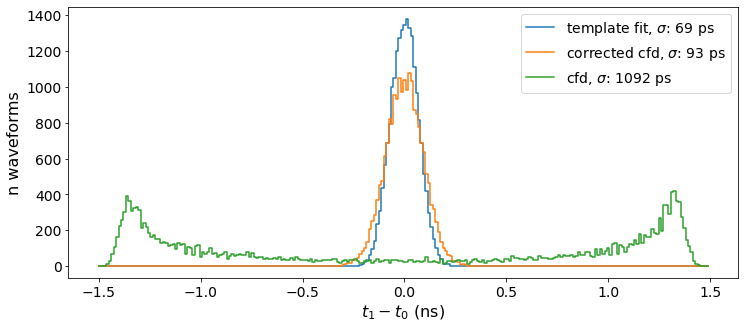

In [34]:
fig, ax = plt.subplots(figsize=(12, 5))
inter_chan_diff_plot(reco_res, (-1.500, 1.500), ax)

In [35]:
# save CFD correction data
fname = f'cfd_cor_250_d{params_250[0]}_s{params_250[1]}_500_d{params_500[0]}_s{params_500[1]}.npz'
phase_cors, phase_zeros = list(zip(*cfd_cors))
np.savez(fname, a=phase_cors, b=phase_zeros)